In [ ]:
import deltaRCM_base
reload(deltaRCM_base)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

class deltaRCM(deltaRCM_base.Tools):

    _input_vars = {
        'model_output__site_prefix': {'name':'site_prefix', 'type': 'string', 'default': ''},
        'model_output__case_prefix': {'name':'case_prefix', 'type': 'string', 'default': ''},
        'model_output__out_dir': {'name':'out_dir', 'type': 'string', 'default': 'deltaRCM_Output/'},
        'model__total_timesteps': {'name':'n_steps', 'type': 'long', 'default': 200},
        'model_grid__length': {'name':'Length', 'type': 'float', 'default': 200.},
        'model_grid__width': {'name':'Width', 'type': 'float', 'default': 500.},
        'model_grid__cell_size': {'name':'dx', 'type': 'float', 'default': 10.},
        'land_surface__width': {'name':'L0_meters', 'type': 'float', 'default': 30.}, 
        'land_surface__slope': {'name':'S0', 'type': 'float', 'default': 0.00015},
        'model__max_iteration': {'name':'itermax', 'type': 'long', 'default': 3},
        'water__number_parcels': {'name':'Np_water', 'type': 'long', 'default': 200},
        'channel__flow_velocity': {'name':'u0', 'type': 'float', 'default': 1.},
        'channel__width': {'name':'N0_meters', 'type': 'float', 'default': 50.},
        'channel__flow_depth': {'name':'h0', 'type': 'float', 'default': 5.},
        'sea_water_surface__elevation': {'name':'H_SL', 'type': 'float', 'default': 0.},
        'sea_water_surface__rate_change_elevation': {'name':'SLR', 'type': 'float', 'default': 0.},
        'sediment__number_parcels': {'name':'Np_sed', 'type': 'long', 'default': 500},
        'sediment__bedload_fraction': {'name':'f_bedload', 'type': 'float', 'default': 0.25}, 
        'sediment__influx_concentration': {'name':'C0_percent', 'type': 'float', 'default': 0.1},                   
        'model_output__opt_eta_figs': {'name':'save_eta_figs', 'type': 'choice', 'default': True},
        'model_output__opt_stage_figs': {'name':'save_stage_figs', 'type': 'choice', 'default': False},
        'model_output__opt_depth_figs': {'name':'save_depth_figs', 'type': 'choice', 'default': False},
        'model_output__opt_eta_grids': {'name':'save_eta_grids', 'type': 'choice', 'default': False},
        'model_output__opt_stage_grids': {'name':'save_stage_grids', 'type': 'choice', 'default': False},
        'model_output__opt_depth_grids': {'name':'save_depth_grids', 'type': 'choice', 'default': False},
        'model_output__opt_time_interval': {'name':'save_dt', 'type': 'long', 'default': 10},
        'coeff__surface_smoothing': {'name': 'Csmooth', 'type': 'float', 'default': 0.9},
        'coeff__under_relaxation__water_surface': {'name': 'omega_sfc', 'type': 'float', 'default': 0.1},
        'coeff__under_relaxation__water_flow': {'name': 'omega_flow', 'type': 'float', 'default': 0.9},
        'coeff__iterations_smoothing_algorithm': {'name': 'Nsmooth', 'type': 'long', 'default': 5},
        'coeff__depth_dependence__water': {'name': 'theta_water', 'type': 'float', 'default': 1.0},
        'coeff__depth_dependence__sand': {'name': 'coeff_theta_sand', 'type': 'float', 'default': 2.0},
        'coeff__depth_dependence__mud': {'name': 'coeff_theta_mud', 'type': 'float', 'default': 1.0},
        'coeff__non_linear_exp_sed_flux_flow_velocity': {'name': 'beta', 'type': 'long', 'default': 3},
        'coeff__sedimentation_lag': {'name': 'sed_lag', 'type': 'float', 'default': 1.0},
        'coeff__velocity_deposition_mud': {'name': 'coeff_U_dep_mud', 'type': 'float', 'default': 0.3},
        'coeff__velocity_erosion_mud': {'name': 'coeff_U_ero_mud', 'type': 'float', 'default': 1.5},
        'coeff__velocity_erosion_sand': {'name': 'coeff_U_ero_sand', 'type': 'float', 'default': 1.05},
        'coeff__topographic_diffusion': {'name': 'alpha', 'type': 'float', 'default': 0.1}
        }


    #############################################
    ################### update ##################
    #############################################

    def update(self):
        '''
        Run the model for one full instance
        '''

        for timestep in range(self.n_steps):
            self.run_one_timestep(timestep)
            self.output_data(timestep)



    #############################################
    ################## __init__ #################
    #############################################

    def __init__(self):
        '''
        Creates an instance of the model

        Sets the most commonly changed variables here
        Calls functions to set the rest and create the domain (for cleanliness)
        '''
        
        self.verbose = True
        self.input_file = 'deltaRCM.in'
        
        self.create_dicts()
        self.set_defaults()
        self.import_file()
        
        self.create_other_variables()
        self.create_domain()




delta = deltaRCM()
delta.update()


Reading input file...
Finished reading 26 variables from input file.
--------------------
Time = 0 of 500
--------------------
Time = 1 of 500
--------------------
Time = 2 of 500
--------------------
Time = 3 of 500
--------------------
Time = 4 of 500
--------------------
Time = 5 of 500
--------------------
Time = 6 of 500
--------------------
Time = 7 of 500
--------------------
Time = 8 of 500
--------------------
Time = 9 of 500
--------------------
Time = 10 of 500


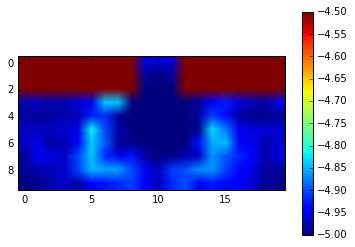

In [205]:
plt.imshow(delta.eta[0:10,40:60], clim = (-5,-4.5))
plt.colorbar()

In [162]:
np.minimum(delta.Vp_dep,delta.Vp_dep)

array([ 12500.,  12500.,  12500.])

In [194]:
delta.dVs

45000.0

In [195]:
delta.dVs / delta.Np_sed

4500.0

In [75]:
delta.eta.shape

(50, 100)

In [77]:
np.zeros((delta.L,delta.W)).shape

(50, 100)

In [197]:
delta.Np_sed

10